### Assessment of personality of worm based on early behavior 
# Step 1: Load data

In [26]:
import personality as prs
import load_data as ld
import helpers as hp
import nan_imputation as ni
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [18]:
# Load data
repo_root = hp.find_repo_root()
optogenetics_path = os.path.join(repo_root, 'Data', 'Optogenetics')
opto_data = ld.load_optogenetics(optogenetics_path)

# Step 2: Preprocessing

### NaN removal

In [12]:
for name, lifespan_array in opto_data.items(): 
    lifespan_arrayxy = lifespan_array[2:4,:]  # Extract columns for X and Y
    missing_sequences = ni.count_successive_missing(lifespan_arrayxy)
    # for start, end, length in missing_sequences:
    #     print(f"  Missing sequence starts at column {start}, ends at column {end - 1}, length: {length}")

# Rows to check for missing values (2:4 in zero-based indexing)
rows_to_check = slice(2, 4)  # Rows 2 and 3 not row 4

# Apply cut_array to each worm in the dataset
cut_nan_dict = {name: ni.cut_array(array, rows_to_check) for name, array in opto_data.items()}

In [13]:
# Print the data after NaN removal
for name, item in cut_nan_dict.items():
    worm_data = cut_nan_dict[name]
    df = pd.DataFrame(worm_data.T, columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light_Pulse' ,'Category'])
    
    # Check for NaN values in the DataFrame
    if df.isna().sum().sum() == 0:
        print(f"Worm {name} has no NaN values after NaN imputation.")
    else:
        print(f"Worm {name} still contains NaN values.")

Worm worm_1 has no NaN values after NaN imputation.
Worm worm_2 has no NaN values after NaN imputation.
Worm worm_3 has no NaN values after NaN imputation.
Worm worm_4 has no NaN values after NaN imputation.
Worm worm_5 has no NaN values after NaN imputation.
Worm worm_6 has no NaN values after NaN imputation.
Worm worm_7 has no NaN values after NaN imputation.
Worm worm_8 has no NaN values after NaN imputation.
Worm worm_9 has no NaN values after NaN imputation.
Worm worm_10 has no NaN values after NaN imputation.
Worm worm_11 has no NaN values after NaN imputation.
Worm worm_12 has no NaN values after NaN imputation.
Worm worm_13 has no NaN values after NaN imputation.
Worm worm_14 has no NaN values after NaN imputation.
Worm worm_15 has no NaN values after NaN imputation.
Worm worm_16 has no NaN values after NaN imputation.
Worm worm_17 has no NaN values after NaN imputation.
Worm worm_18 has no NaN values after NaN imputation.
Worm worm_19 has no NaN values after NaN imputation.
Wo

### Splitting the data

In [19]:
train_worms, test_worms = ld.split_worms(cut_nan_dict, test_size=0.2)

print(f"Training Worms: {list(train_worms.keys())}")
print(f"Testing Worms: {list(test_worms.keys())}")

Training Worms: ['worm_10', 'worm_4', 'worm_11', 'worm_27', 'worm_38', 'worm_19', 'worm_40', 'worm_26', 'worm_5', 'worm_34', 'worm_23', 'worm_12', 'worm_30', 'worm_22', 'worm_13', 'worm_25', 'worm_36', 'worm_37', 'worm_33', 'worm_14', 'worm_24', 'worm_21', 'worm_29', 'worm_39', 'worm_31', 'worm_20', 'worm_17', 'worm_42', 'worm_35', 'worm_32', 'worm_1', 'worm_3', 'worm_28']
Testing Worms: ['worm_6', 'worm_7', 'worm_9', 'worm_15', 'worm_16', 'worm_18', 'worm_2', 'worm_8', 'worm_41']


In [20]:
# Iterate through each worm in the dictionary
for worm_name, worm_data in cut_nan_dict.items():
    # Count the number of `1`s in column 5
    light_pulse_count = np.sum(worm_data[5, :] == 1)
    
    # Print the result
    print(f"{worm_name}: {light_pulse_count} light pulses detected.")

worm_1: 335 light pulses detected.
worm_2: 344 light pulses detected.
worm_3: 618 light pulses detected.
worm_4: 609 light pulses detected.
worm_5: 576 light pulses detected.
worm_6: 512 light pulses detected.
worm_7: 617 light pulses detected.
worm_8: 1030 light pulses detected.
worm_9: 943 light pulses detected.
worm_10: 1125 light pulses detected.
worm_11: 1155 light pulses detected.
worm_12: 1063 light pulses detected.
worm_13: 930 light pulses detected.
worm_14: 923 light pulses detected.
worm_15: 988 light pulses detected.
worm_16: 1095 light pulses detected.
worm_17: 922 light pulses detected.
worm_18: 1109 light pulses detected.
worm_19: 1148 light pulses detected.
worm_20: 960 light pulses detected.
worm_21: 1078 light pulses detected.
worm_22: 1049 light pulses detected.
worm_23: 285 light pulses detected.
worm_24: 353 light pulses detected.
worm_25: 270 light pulses detected.
worm_26: 332 light pulses detected.
worm_27: 346 light pulses detected.
worm_28: 587 light pulses de

# Step 3: Clustering

### Feature matrix

In [39]:
# `cut_nan_dict` is a dictionary of preprocessed worm data
worm_dataframes = []

# Iterate over each worm in cut_nan_dict
for worm_name, worm_array in cut_nan_dict.items():
    # Convert the NumPy array to a pandas DataFrame
    worm_df = pd.DataFrame(
        worm_array.T,  # Transpose the array (features as columns)
        columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light_Pulse', 'Category']  # Add column names
    )
    worm_dataframes.append(worm_df)

# Check if conversion worked
print(f"Converted {len(worm_dataframes)} worms into DataFrames.")

# Use create_feature_matrix to generate features
feature_matrix = prs.create_feature_matrix(worm_dataframes, percentile=50)

# Display the feature matrix
print("Feature Matrix:")
print(feature_matrix.head())

# # Save the feature matrix to a CSV file for inspection
# output_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'feature_matrix.csv')
# feature_matrix.to_csv(output_path, index=False)
# print(f"Feature Matrix saved to: {output_path}")


Converted 42 worms into DataFrames.
Feature Matrix:
  worm_name  average_speed  variance_speed  threshold  movement_frequency  \
0    Worm 1       4.368967     1138.798265   1.066618           50.000000   
1    Worm 2       1.623409      363.418113   0.749258           49.999349   
2    Worm 3       2.886690      256.786384   1.011278           50.000000   
3    Worm 4       2.356340      123.662434   1.136713           49.999637   
4    Worm 5       2.050638       38.852848   1.098204           49.999625   

   active_time_ratio  total_distance  area_explored  
0           0.500000   209348.417733  297341.655305  
1           0.499993    88413.638818  348324.705543  
2           0.500000   355714.494935  268988.276081  
3           0.499996   276649.186244  183695.000864  
4           0.499996   142184.069605  210705.781073  


### Hierarchical clustering to find the number of clusters

Dendrogram saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\hierarchical_dendrogram.png


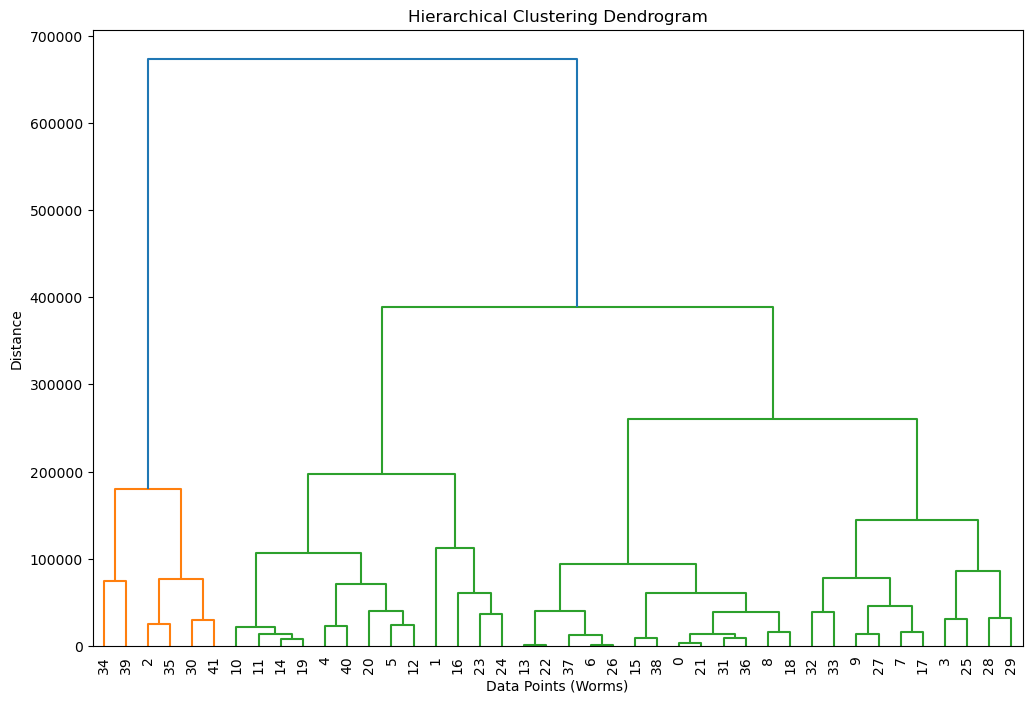

In [40]:
# Prepare input for clustering -> drop non-numeric columns like 'worm_name' or any other metadata
feature_matrix_copy = feature_matrix.copy()
clustering_input = feature_matrix_copy.drop(columns=['worm_name'])

# Define the output path for the dendrogram
dendrogram_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'hierarchical_dendrogram.png')

# Ensure the directory exists
os.makedirs(os.path.dirname(dendrogram_path), exist_ok=True)

# Perform hierarchical clustering and save the dendrogram
prs.perform_hierarchical_clustering(
    feature_matrix=clustering_input,  # Pass only numeric data
    method='ward',
    output_file=dendrogram_path
)

print(f"Dendrogram saved to: {dendrogram_path}")

In [41]:
# Define the personality mapping
# personality_map = {
#     0: "Fast Worms",
#     1: "Exploratory Worms",
#     2: "Active Worms",
#     3: "Inactive Worms"
# }

personality_map = {
    0: "Custer 0",
    1: "Custer 1",
    2: "Custer 2",
    3: "Custer 3"
}

# Perform K-Means clustering
num_clusters = 4  # Based on the dendrogram analysis
clustered_feature_matrix = prs.perform_kmeans_clustering(
    feature_matrix=clustering_input,
    num_clusters=num_clusters,
    personality_map=personality_map
)

# Preserve worm names for reference
worm_names = feature_matrix['worm_name']
# Reattach worm names to the clustered feature matrix
clustered_feature_matrix['worm_name'] = worm_names.values


# Display the updated feature matrix with clusters
print("Clustered Feature Matrix:")
print(clustered_feature_matrix[['worm_name', 'Cluster', 'Personality']])

# # Save the clustered feature matrix to a CSV file
# clustered_output_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'clustered_feature_matrix.csv')
# os.makedirs(os.path.dirname(clustered_output_path), exist_ok=True)  # Ensure the directory exists
# clustered_feature_matrix.to_csv(clustered_output_path, index=False)
# print(f"Clustered feature matrix saved to: {clustered_output_path}")

Clustered Feature Matrix:
   worm_name  Cluster Personality
0     Worm 1        0    Custer 0
1     Worm 2        0    Custer 0
2     Worm 3        1    Custer 1
3     Worm 4        1    Custer 1
4     Worm 5        2    Custer 2
5     Worm 6        2    Custer 2
6     Worm 7        0    Custer 0
7     Worm 8        0    Custer 0
8     Worm 9        0    Custer 0
9    Worm 10        1    Custer 1
10   Worm 11        2    Custer 2
11   Worm 12        2    Custer 2
12   Worm 13        2    Custer 2
13   Worm 14        0    Custer 0
14   Worm 15        2    Custer 2
15   Worm 16        0    Custer 0
16   Worm 17        2    Custer 2
17   Worm 18        0    Custer 0
18   Worm 19        0    Custer 0
19   Worm 20        2    Custer 2
20   Worm 21        2    Custer 2
21   Worm 22        0    Custer 0
22   Worm 23        0    Custer 0
23   Worm 24        2    Custer 2
24   Worm 25        2    Custer 2
25   Worm 26        1    Custer 1
26   Worm 27        0    Custer 0
27   Worm 28        1 

c:\Users\msgar\miniconda3\envs\env_ML\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
# Calculate the mean values for each feature within each cluster
cluster_summary = clustered_feature_matrix.groupby('Cluster').mean()

print("Cluster Summary:")
print(cluster_summary)

### PCA plot

PCA plot saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\pca_clusters.png


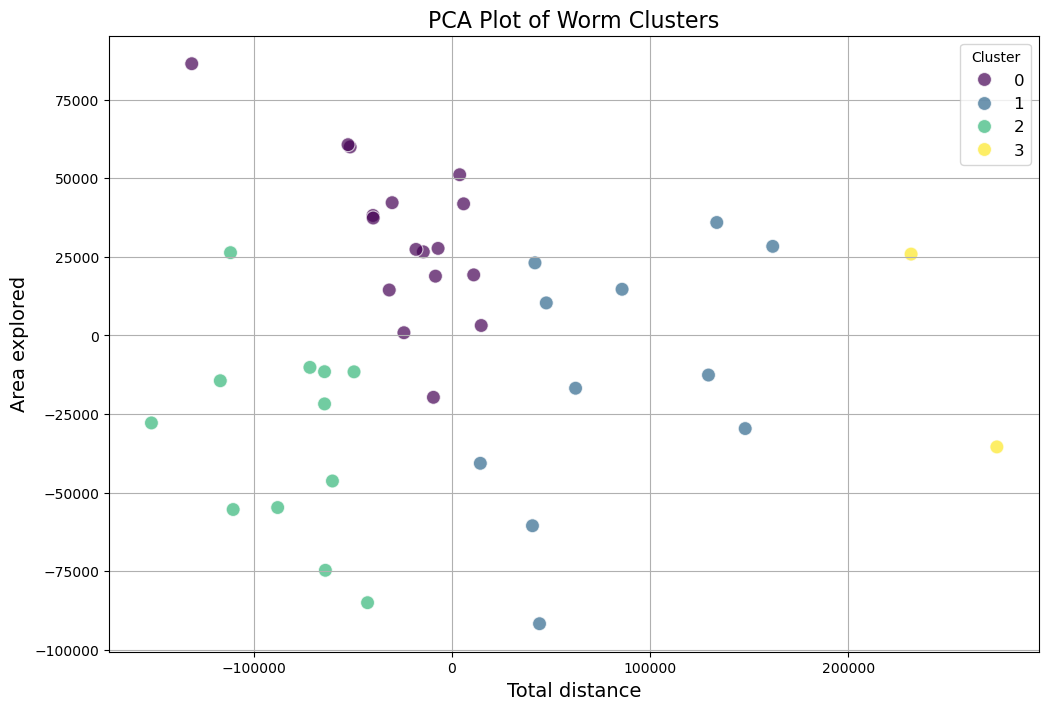

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for PCA
clustered_feature_matrix_PCA = clustered_feature_matrix.copy()
numeric_features = clustered_feature_matrix_PCA.drop(columns=['worm_name', 'Cluster', 'Personality'])  # Drop non-numeric columns
cluster_labels = clustered_feature_matrix_PCA['Cluster']  # Save the cluster labels

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_features)

# Add PCA results to the clustered feature matrix
clustered_feature_matrix_PCA['PCA1'] = pca_result[:, 0]
clustered_feature_matrix_PCA['PCA2'] = pca_result[:, 1]

# Plot the PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',  # Color by cluster
    data=clustered_feature_matrix_PCA,
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('PCA Plot of Worm Clusters', fontsize=16)
plt.xlabel('Total distance', fontsize=14)
plt.ylabel('Area explored', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)

# Save the PCA plot
pca_plot_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'pca_clusters.png')
plt.savefig(pca_plot_path)
print(f"PCA plot saved to: {pca_plot_path}")

# Show the plot
plt.show()


In [45]:
# Get the PCA loadings (weights of each feature for each component)
pca_loadings = pd.DataFrame(
    pca.components_,
    columns=numeric_features.columns,
    index=['PCA1', 'PCA2']
)

print("PCA Loadings:")
print(pca_loadings)

PCA Loadings:
      average_speed  variance_speed     threshold  movement_frequency  \
PCA1   7.030044e-06        0.001751  5.798522e-07        4.307705e-10   
PCA2  -4.451725e-07        0.000280  3.037353e-07        7.879214e-10   

      active_time_ratio  total_distance  area_explored  
PCA1       4.307705e-12        0.997205       0.074699  
PCA2       7.879214e-12       -0.074700       0.997206  


From this, PCA1 (x-axis) is more influenced by total distance (0.997205),
and PCA2 (y-axis) is more influenced by area explored (0.997206)

# Step 4: Classification